In [1]:
import torch
import pickle as pkl
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.data import Batch
import torch.nn as nn
from sklearn.manifold import TSNE
from rdkit import Chem
%matplotlib inline
import matplotlib.pyplot as plt
from GNN_atom import GNN
from Dataset import XASDataset
from utils import plot_spectra,plot_learning_curve

/p/software/juwelsbooster/stages/2023/software/tqdm/4.64.0-GCCcore-11.3.0/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Define routines to be used

In [2]:
def train(epoch):
    model.train()
    loss_all = 0
    node_list = []
    select_list = []
    tot_list = []
    smiles_list = []
   # batch_size = 128
    for batch in train_loader:
        
        #print(batch.idx,batch.smiles)
        batch = batch.to(device)
        #x, edge_index,index = batch.x,batch.edge_index,batch.index
       
        #print(batch.idx,batch.atom_index)
        # Add batch dimension to index
        #batch_index = index.unsqueeze(1)

        optimizer.zero_grad()
        
        pred,node,select,tot = model(batch)
        batch_size = batch.y.shape[0] // 200
        batch.y = batch.y.view(batch_size, 200)
        #pred = torch.clamp(pred, min=0.0)
        #print(batch.y.shape)
        #new_pred=pred.view(batch.y[:,0:99].shape)

        #pred=ss[0]
        #emb=ss[1]
        alpha = 10

        #loss = nn.MSELoss()(pred.view(-1, 1).double(), 
        #                batch.y[:,:100].view(-1, 1).double()) 
        
        loss = nn.MSELoss()(pred.double(), 
                       batch.y.double()) 
       # + alpha*F.mse_loss(torch.log(pred.view(-1, 1).double()+0.001), torch.log(batch.y.view(-1, 1).double()+0.001))
        
        #p_loss=nn.SmoothL1Loss()(new_pred.double(), 
        #                batch.y.double())
        
        #loss=nn.SmoothL1Loss()(pred.view(-1, 1).double(), 
        #                batch.y.view(-1, 1).double())
        #print(loss)
        #print(pred.view(-1, 1).double(), batch.y.view(-1, 1).double())
       # pred_list.append(pred.view(-1, 1).double())
        #y_list.append(batch.y.view(-1, 1).double())
        
        loss.backward()
        #print(batch.num_graphs)
        loss_all += loss.item() * batch.num_graphs
        optimizer.step()
        
        if epoch == 999 :
            node_list.append(node)
            select_list.append(select)
            smiles_list.append(batch.smiles)
            tot_list.append(tot)
    a = 0
    b = 0
    c = 0
    d = 0
    if epoch == 999:
        a = node_list
        b = select_list
        c = smiles_list
        d = tot_list
    
    #print(len(train_loader.dataset))
        #emb_list.append(emb)
    return loss_all / len(train_loader.dataset),a,b,c,d

In [3]:
def test(loader):
    model.eval()
    loss_all = 0

    for batch in loader:
        batch = batch.to(device)
        #x, edge_index, index = batch.x, batch.edge_index, batch.index
        
        # Add batch dimension to index
        #batch_index = index.unsqueeze(1)
        batch_size = batch.y.shape[0] // 200
        batch.y = batch.y.view(batch_size, 200)

        with torch.no_grad():
            pred,node,select,tot = model(batch)
        
        
        #print(pred)
   #     alpha=10
       # loss = nn.MSELoss()(pred.view(-1, 1).double(),
        #                  batch.y.view(-1, 1).double()) 
        
        loss = nn.MSELoss()(pred.double(),
                          batch.y.double()) 
    #    +alpha*F.mse_loss(torch.log(pred.view(-1, 1).double()+0.001), torch.log(batch.y.view(-1, 1).double()+0.001))
       # loss=nn.SmoothL1Loss()(pred.view(-1, 1).double(), 
       #                 batch.y.view(-1, 1).double())
        loss_all += loss.item() * batch.num_graphs

    return loss_all / len(loader.dataset)

#### Load the data

In [4]:
# Path raw directory containing the data
path = "/p/project/hai_ml_xas/Sam_ML/GO_molecule_GNN"
# Load and create the dataset
dataset = XASDataset(path)

In [5]:
print("Total number of data points in the dataset:", len(dataset))

Total number of data points in the dataset: 7946


#### Split into test, validation and test datasets

In [6]:
train_dataset = dataset[0:6277]
val_dataset = dataset[6277:6975]
test_dataset = dataset[6975:]

In [7]:
train_dataset[0]

Data(x=[32, 16], edge_index=[2, 78], y=[200], edge_attrs=[78, 7], idx=[1], smiles='[c:0]12[c:4]3[c:8]4[c:10]5[c:11]([CH:25]=[O:29])[cH:13][c:14]6[c:12]4[c:17]4[c:19]([c:18]([CH:26]=[O:31])[c:15]6[OH:16])=[CH:20][CH:22]6[C:23]([c:21]14)([CH:24]=[CH:1][C:2]2=[CH:3][CH2:5][C:6]3([CH:27]=[O:30])[CH:7]=[CH:9]5)[O:28]6', atom_num=[1], neigbors=[3])

In [15]:
train_dataset

XASDataset(6277)

In [9]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#### Set neural network properties

In [10]:
num_tasks = 200
num_layers = 4
emb_dim = dataset.num_features
print(emb_dim)
in_channels = [int(emb_dim),100,200,300]
print(in_channels)
out_channels = [100,200,300,300]
gnn_type = 'gcn'
heads = int(1)
drop_ratio = 0.8
graph_pooling = 'attention'

16
[16, 100, 200, 300]


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
model = model.to(device)

In [12]:
model

GNN(
  (gnn_node): GNN_node(
    (convs): ModuleList(
      (0): GCNConv(16, 100)
      (1): GCNConv(100, 200)
      (2): GCNConv(200, 300)
      (3): GCNConv(300, 300)
    )
    (batch_norms): ModuleList(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (pool): AttentionalAggregation(gate_nn=Linear(in_features=300, out_features=1, bias=True), nn=None)
  (graph_pred_linear): Linear(in_features=600, out_features=200, bias=True)
)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                    factor=0.5, patience=100,
                                                    min_lr=0.000001)
#scheduler =torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,300,500], gamma=0.5)

#### Run neural network training

In [14]:
best_val_error = None
train_losses = []
val_losses = []

for epoch in range(0, 1000):
    
    loss,a,b,c,d = train(epoch)
    
    val_error = test(val_loader)
    scheduler.step(val_error)
    #scheduler.step(epoch)
    train_losses.append(loss)
    val_losses.append(val_error)
    
    current_lr = optimizer.param_groups[0]['lr']
    


    if best_val_error is None or val_error <= best_val_error:
        
        best_val_error = val_error
    if epoch%10==0:
        print(f'Epoch: {epoch:03d}, LR: {current_lr:7f}, TrainLoss: {loss:.7f}, ValLoss:{val_error:7f}, Best_ValLoss:{best_val_error:7f}')


RuntimeError: The size of tensor a (23569) must match the size of tensor b (3367) at non-singleton dimension 0

In [15]:
torch.save(model.state_dict(), "ML_models/model_gnn_atom_2.pt")

#### View loss

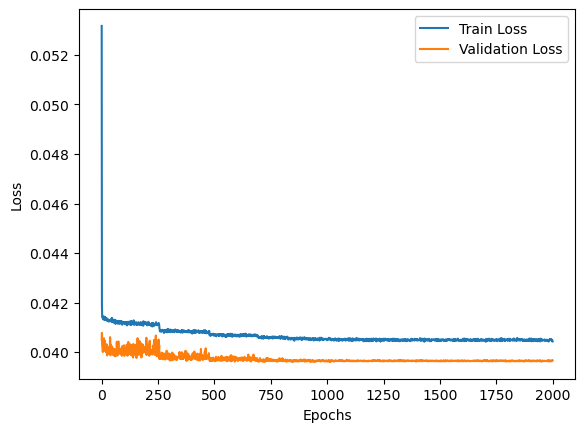

In [16]:
num_e = 1000

plot_learning_curve(num_e, train_losses, val_losses)

#### Load model and predict spectra

In [13]:
# Load the saved model
num_tasks = 200

model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
mode = model.to(device)
model.load_state_dict(torch.load("ML_models/model_gnn_atom_2.pt"))

<All keys matched successfully>

#### Plot predicted spectra

In [19]:
# Create empty dictionary to contain spectra
predict = {}
true = {}

# Loop over all molecules in test dateset and assign to dictionary index
for index in range(len(test_dataset)):
    predict[index], true[index] = pred_spec(model, index, test_dataset)

971


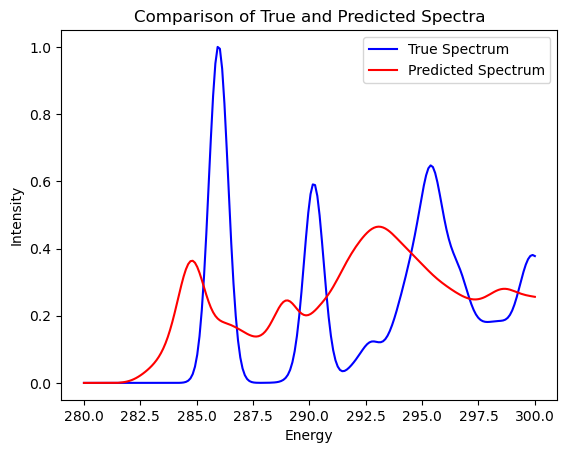

In [15]:
save_var = 1

plot_spectra(predict[200], true[200], save_var)

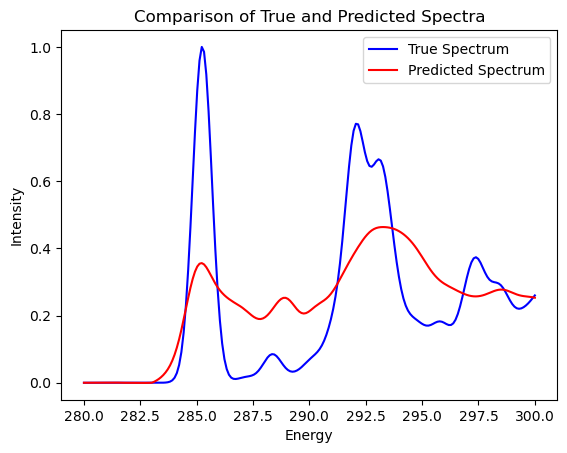

In [16]:
plot_spectra(predict[500], true[500], save_var)

In [17]:
model_dict = [predict, true]

#### Save spectra

In [18]:
with open("/p/project/hai_ml_xas/Sam_ML/GO_molecule_GNN/spectra_results/spectra_ml_atom_2.pkl", "wb") as file:
    pkl.dump(model_dict, file)

In [ ]:
t0 = train_dataset[30]

In [ ]:
t0.x

In [ ]:
model.eval()
for batch in train_loader:
    batch = batch.to(device)
    embeddings = model.forward(batch)

In [ ]:
embeddings[1][0]

In [ ]:
embeddings[1][1]